In [68]:
# %load_ext iminizinc
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
# import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
from decimal import *
getcontext().prec = 6
import seaborn as sns
from scipy.signal import find_peaks, peak_widths
import pickle


import sys, os
# sys.path.append(os.path.abspath('..'))
# from research.pkg.lib import *


# import mplfinance as mpf
%matplotlib inline

plt.rcParams['lines.linewidth'] = 0.5 

mpl.rcParams.update({'font.size': 4, 'lines.linewidth': 0.5, 'figure.dpi': 150})


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
pair = 'BTC_USDT'
timeframe = '4h'

exchange = 'binance'
odf = pd.read_json(f'../../freq-user-data/data/{exchange}/{pair}-{timeframe}.json'
# exchange = 'kucoin'
# odf = pd.read_json(f'../../freq-user-data/data/{exchange}/futures/{pair}-{timeframe}-futures.json'
).dropna().set_axis(['timestamp', 'open', 'high', 'low', 'close', 'volume'], axis=1
).assign(dtime=lambda x: pd.to_datetime(x['timestamp'], unit='ms', utc=False)
).set_index('dtime').sort_index()

print(odf.shape)
odf.tail(4)

(12676, 6)


,timestamp,open,high,low,close,volume
dtime,,,,,,
2023-06-01 20:00:00,1685649600000,26862.68,26942.98,26713.34,26817.93,3659.35611
2023-06-02 00:00:00,1685664000000,26817.93,27017.00,26505.00,27000.00,7016.04160
2023-06-02 04:00:00,1685678400000,27000.01,27213.00,26949.40,27049.65,6856.64454
2023-06-02 08:00:00,1685692800000,27049.65,27183.07,27049.38,27130.75,3577.11000


In [31]:
odf.shape[0] // l * l , odf.shape[0]

(12670, 12676)

In [34]:
l = 14
# np.split(odf.close[- (odf.shape[0] // l * l):] ,l)
X_train = to_time_series_dataset(np.split(odf.close[- (odf.shape[0] // l * l):] ,l))

In [10]:
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMinMax

In [12]:
# X = to_time_series_dataset(xdf[['close','low','high']].values.T)
# X_scaled = TimeSeriesScalerMinMax().fit_transform(X)
# X_scaled[:5]

array([[[0.02350761],
        [0.02103598],
        [0.02171899],
        ...,
        [0.73529991],
        [0.73875671],
        [0.74440316]],

       [[0.02973527],
        [0.03092821],
        [0.03202265],
        ...,
        [0.71081541],
        [0.7416375 ],
        [0.74857177]],

       [[0.01836491],
        [0.01753416],
        [0.01890952],
        ...,
        [0.72471992],
        [0.73826621],
        [0.73619764]]])

Euclidean k-means
7.537 --> 4.279 --> 4.279 --> 
DBA k-means
Init 1
2.580 --> 1.166 --> 1.166 --> 
Init 2
2.325 --> 1.328 --> 1.328 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Soft-DTW k-means
16.681 --> 3.371 --> 3.377 --> 3.360 --> 3.373 --> 3.366 --> 3.366 --> 3.366 --> 3.366 --> 3.366 --> 3.366 --> 


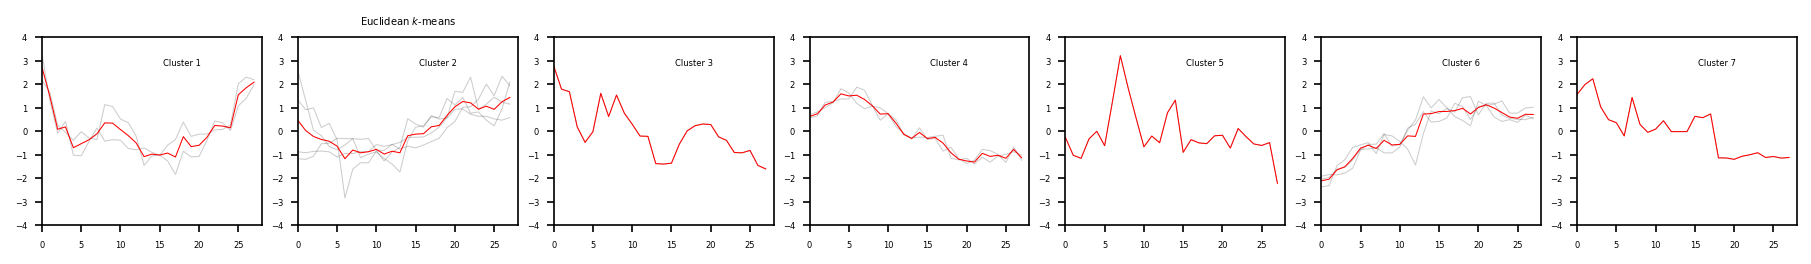

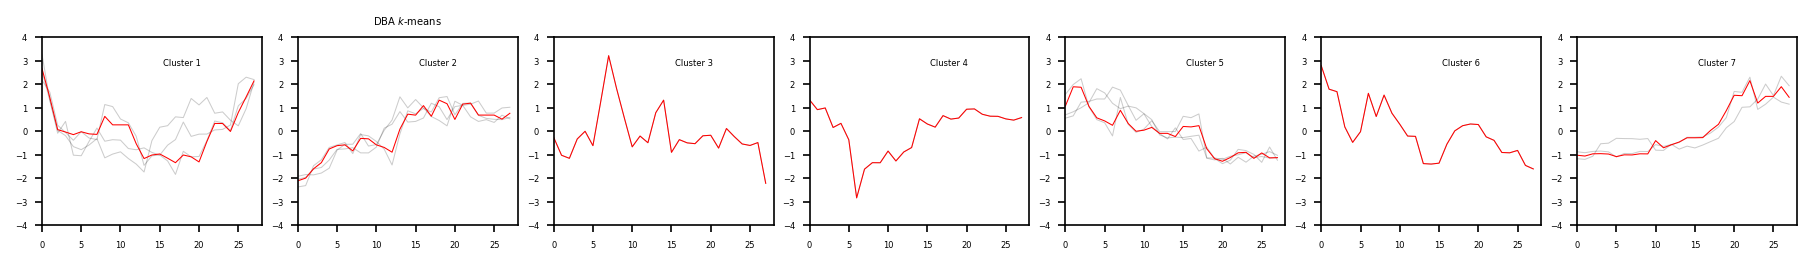

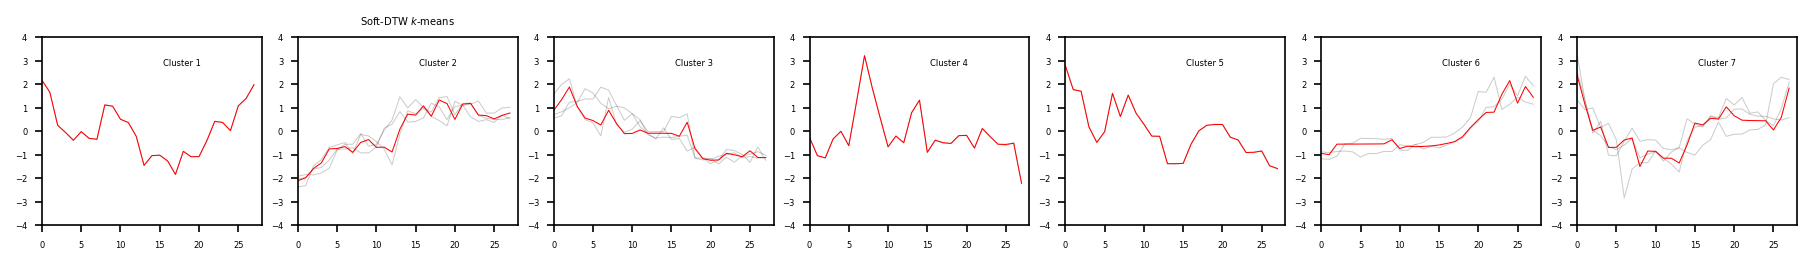

In [79]:

import numpy
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

seed = 0
numpy.random.seed(seed)
# X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
# X_train = X_train[y_train < 4]  # Keep first 3 classes
# X_train = to_time_series_dataset(odf[['close']].values.T)
l = 7 * 2
n_clusters = 7
X_train = to_time_series_dataset(np.split(odf.close[- (odf.shape[0] // l * l):] ,l))
numpy.random.shuffle(X_train)
# Keep only 50 time series
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train[:50])
# Make time series shorter
X_train = TimeSeriesResampler(sz=l*2).fit_transform(X_train)
sz = X_train.shape[1]

# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True, random_state=seed)
y_pred = km.fit_predict(X_train)


ppl = 7
ppc = (n_clusters // ppl + 1) 
pr = ppc * 3

plt.figure(figsize=(12,3))

for yi in range(n_clusters):
    plt.subplot(ppc , ppl, yi + 1 )
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")
plt.tight_layout()

# DBA-k-means
plt.figure(figsize=(12,3))
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred = dba_km.fit_predict(X_train)

for yi in range(n_clusters):
    # plt.subplot(3, 3, 4 + yi)
    plt.subplot(ppc , ppl, yi + 1 )
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")
plt.tight_layout()

# Soft-DTW-k-means
plt.figure(figsize=(12,3))
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=n_clusters,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
y_pred = sdtw_km.fit_predict(X_train)

for yi in range(n_clusters):
    plt.subplot(ppc , ppl, yi + 1 )
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

plt.tight_layout()
plt.show()